In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import ot
import pandas as pd
import math
import tqdm
import seaborn as sns
import sys
sys.path.append('../src')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

def generate_gaussian_mixture(size, proportions, means, std_devs):
    assert len(proportions) == len(means) == len(std_devs), "All parameters should have the same length"
    assert np.isclose(sum(proportions), 1), "Proportions should sum to 1"
    
    data = []
    labels = []
    for i, (proportion, mean, std_dev) in enumerate(zip(proportions, means, std_devs)):
        num_samples = int(size * proportion)
        samples = np.random.normal(mean, std_dev, num_samples)
        data.append(samples)
        labels.append([i]*num_samples)
    
    return np.concatenate(data), np.concatenate(labels)

def solve_quadratic_equation(a, b, c): 
    if a==0:
        sol = -c/b
        return sol, sol
    else:
        # calculating discriminant using formula
        dis = b * b - 4 * a * c 
        sqrt_val = math.sqrt(abs(dis)) 

        # checking condition for discriminant
        if dis > 0: 
            
            sol1 = (-b + sqrt_val)/(2 * a)
            sol2 = (-b - sqrt_val)/(2 * a)
#             print("real and different roots")
#             print((-b + sqrt_val)/(2 * a)) 
#             print((-b - sqrt_val)/(2 * a)) 

        elif dis == 0: 
            
            sol1 = -b / (2 * a)
            sol2 = -b / (2 * a)
#             print("real and same roots") 
#             print(-b / (2 * a)) 

        # when discriminant is less than 0
        else:
#             print("Complex Roots, not considered here")
            sol1 = 0
            sol2 = 0
        return sol1, sol2
        

def get_optimal_treshold(mu0, sigma0, mu1, sigma1, p0, p1):
    sigma0_sq = sigma0**2
    sigma1_sq = sigma1**2
    mu0_sq = mu0**2
    mu1_sq = mu1**2
    
    a = (-1/2) * (1/sigma1_sq) + (1/2) * (1/sigma0_sq)
    b = (mu1/sigma1_sq) - (mu0/sigma0_sq)
    c = (-1/2) * (mu1_sq/sigma1_sq) + (1/2) * (mu0_sq/sigma0_sq) + \
    np.log(p1) - np.log(p0) + np.log(sigma0) - np.log(sigma1)
    
    sol1, sol2 = solve_quadratic_equation(a, b, c)
    return sol1, sol2

# Set random seed for reproducibility
np.random.seed(42)

# Generate training set
size_1 = 10000
proportions_1 = [0.1, 0.9]
means = [-1, 1]
std_devs = [1, 1]

# Generate test set of features
num_iters = 100
size_2 = 10000
    

tv_list = []
naive_acc_list = []
ot_acc_list = []
bayes_acc_list = []

# sns.set_style('whitegrid')
    
for _ in tqdm.trange(num_iters):
    for positive_rate in np.arange(0.9, 0.1, -0.05):
        X_train, y_train = generate_gaussian_mixture(size_1, proportions_1, means, std_devs)
        X_train = X_train.reshape((-1, 1))
        proportions_2 = [1-positive_rate, positive_rate]
        X_test, y_test = generate_gaussian_mixture(size_2, proportions_2, means, std_devs)
#         print(proportions_2)
#         sns.kdeplot(X_test, label='all')
#         sns.kdeplot(X_test[y_test==0], label='Y=0')
#         sns.kdeplot(X_test[y_test==1], label='Y=1')
#         plt.legend()
#         plt.show()
        
        X_test = X_test.reshape((-1, 1))
        
        model = LogisticRegression()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        naive_acc = accuracy_score(y_test, y_pred)
        
        ## with ot
        y_proba = model.predict_proba(X_test)
        nu_true = np.array(proportions_2)
#         nu_true = compute_class_balance(y_test)
        M = -np.log(y_proba)
        
#         M = 1 - y_proba
        # define marginals
        n_samples, n_classes = y_proba.shape
        src = np.ones(n_samples) / n_samples
        tgt = np.ones(n_classes) * nu_true

        # run OT
        T = ot.emd(src, tgt, M, numItermax=10000000)
        pred = T.argmax(axis=1)
        ot_acc = accuracy_score(y_test, pred)
        
        # Bayes
        optimal_threshold1, optimal_threshold2 = get_optimal_treshold(means[0], std_devs[0], means[1], std_devs[1],
                                                1-positive_rate, positive_rate)
#         print('optimal_treshold:', optimal_threshold, 'nu_true', nu_true)
        pred1 = (X_test >= optimal_threshold1)
        pred2 = (X_test >= optimal_threshold2)
    
        bayes_acc = max(accuracy_score(y_test, pred1), accuracy_score(y_test, pred2))
        
        tv_list.append(0.5*np.sum(np.abs(np.array(proportions_1) - np.array(proportions_2))))
        naive_acc_list.append(naive_acc)
        ot_acc_list.append(ot_acc)
        bayes_acc_list.append(bayes_acc)

100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


In [2]:
df = pd.DataFrame(
    {
        'tv': tv_list,
        'naive_acc': naive_acc_list,
        'ot_acc': ot_acc_list,
        'bayes_acc': bayes_acc_list
    }
)

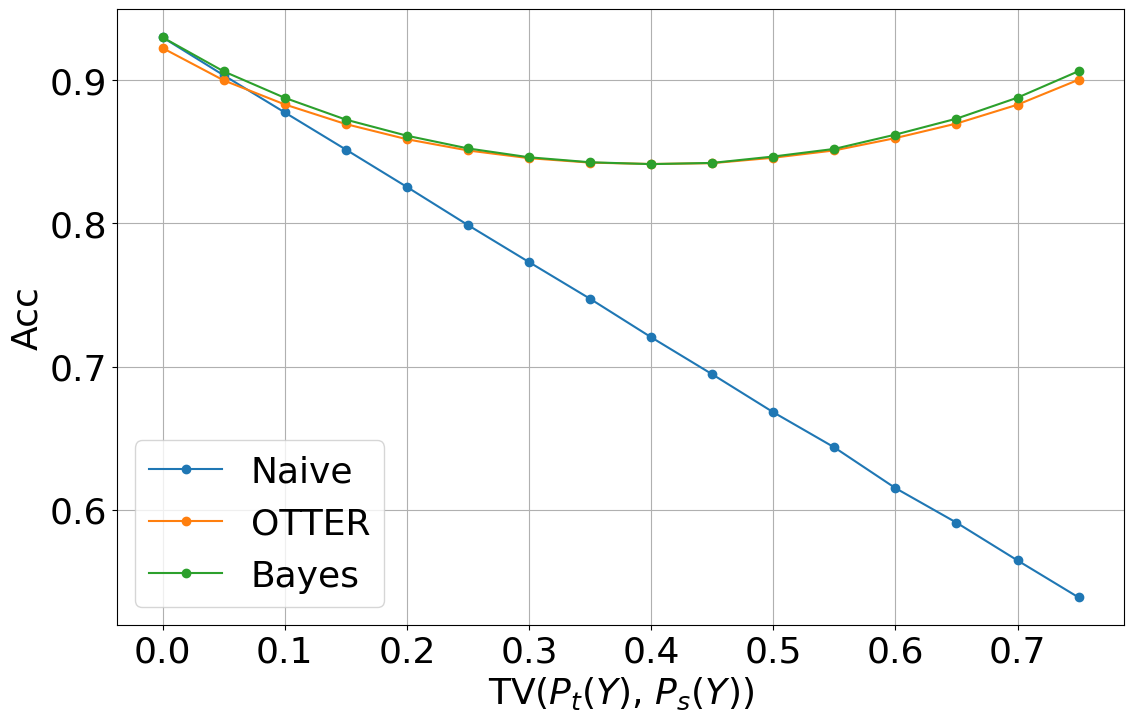

In [3]:
plt.rcParams.update({'font.size': 26})

tv = df['tv'].unique()
naive_acc = df.groupby('tv')['naive_acc'].mean()
ot_acc = df.groupby('tv')['ot_acc'].mean()
bayes_acc = df.groupby('tv')['bayes_acc'].mean()

plt.figure(figsize=(13, 8))
plt.plot(tv, naive_acc, 'o-', label='Naive')
plt.plot(tv, ot_acc, 'o-', label='OTTER')
plt.plot(tv, bayes_acc, 'o-', label='Bayes')
plt.xlabel('TV($P_{t}(Y)$, $P_{s}(Y))$')
plt.ylabel('Acc')
plt.grid()
plt.legend()
plt.show()
